# 순서형 프로빗/로지스틱 회귀분석
최종 사고데이터셋 : 각 사고지점별 및 사고일시별 변수로 구성

In [ ]:
# For Google Colab
from google.colab import drive
drive.mount('/content/Mydrive')
%cd '/content/Mydrive/MyDrive/IOT_hackathon/Github/IOT_hackathon'

Mounted at /content/Mydrive
/content/Mydrive/.shortcut-targets-by-id/1c0Uj2m_Fj74QB5yN9JL2QhAIJ1ijbINP/IOT_hackathon/Github/IOT_hackathon


In [ ]:
# !pip install statsmodels # for colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Packages

import numpy as np
import pandas as pd
import scipy.stats as stats


from statsmodels.miscmodels.ordinal_model import OrderedModel
from copy import deepcopy
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 데이터 로드 및 전처리
- 사고내용(심각도) : 4단계로 순서형 변수로 처리함
- 연령 : 텍스트 데이터로 되어있어 정수형으로 처리함

In [ ]:
df = pd.read_csv('Dataset.csv')
df_temp = pd.read_csv('RealRealFinal.csv', usecols=['temp','humidity','dust'])
df['temp'] = df_temp.temp
df['humidity'] = df_temp.humidity
df['dust'] = df_temp.dust

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['부상신고사고','경상사고','중상사고','사망사고'],ordered=True)
df.사고내용 = df.사고내용.astype(cat_type)

df = df.loc[df['가해운전자 연령'] != '미분류', :]

for i in range(len(df)):
    df.iloc[i,13] = df.iloc[i,13][:-1]

df['가해운전자 연령'] = df['가해운전자 연령'].astype('int')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
# descriptive statistics
df.describe().round(1)

,Unnamed: 0,사망자수,중상자수,경상자수,부상신고자수,가해운전자 연령,X,Y,day,hour,...,학교_대,따릉이_대여소수,pubs,speedbump,busstop,subway,bus,temp,humidity,dust
count,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,...,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0,439.0
mean,221.5,0.0,0.2,0.7,0.2,30.3,200956.1,448823.1,3.0,14.7,...,0.0,2.0,29.8,26.9,8.1,3.6,88.5,18.6,61.0,30.0
std,128.6,0.0,0.4,0.6,0.4,12.3,7009.8,5305.9,1.9,6.1,...,0.1,1.6,45.2,40.0,4.8,2.1,29.4,9.9,21.5,43.4
min,0.0,0.0,0.0,0.0,0.0,9.0,183027.2,440700.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,16.0,-40.0,13.0,0.0
25%,111.0,0.0,0.0,0.0,0.0,22.0,194714.7,444771.0,1.0,10.0,...,0.0,1.0,6.0,0.0,5.0,2.0,67.0,13.2,46.0,11.0
50%,221.0,0.0,0.0,1.0,0.0,27.0,202748.6,447095.5,3.0,16.0,...,0.0,2.0,16.0,10.0,7.0,3.0,84.0,20.1,58.0,20.2
75%,332.5,0.0,0.0,1.0,0.0,34.0,206207.6,451579.8,5.0,20.0,...,0.0,3.0,35.5,35.0,11.0,5.0,109.5,24.4,76.0,35.0
max,444.0,1.0,2.0,2.0,2.0,81.0,215090.2,464343.6,6.0,23.0,...,1.0,9.0,321.0,182.0,24.0,13.0,175.0,39.5,100.0,635.0


In [ ]:
# SDOT_pop
df_1 = deepcopy(df)

In [ ]:
df_2 = df_1.loc[df_1.SDoT_pop>0,:]
df_2 = df_2[df_2.columns.drop(['count_따릉이','bus','Unnamed: 0'])] # 불필요한 데이터 삭제 

## 상관계수 확인 및 Plot

In [ ]:
# Correlation among predictors
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20))

corr = df_2.corr()
mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask = mask,
annot = True, linewidth=.5,
cmap = 'RdYlBu_r', cbar_kws = {"shrink": .3}, # shrink cbar(cmap)
vmin = -1, vmax = 1)
plt.show()
plt.savefig('plots/corr.png', facecolor = 'white', transparent = False)

### 히스토그램으로 각 변수(독립변수) 분포 파악

<AxesSubplot:>

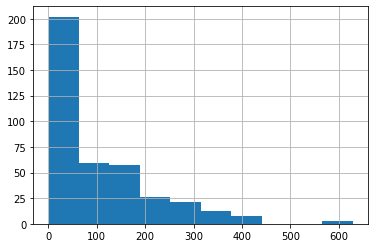

In [ ]:
df_2.SDoT_pop.hist()

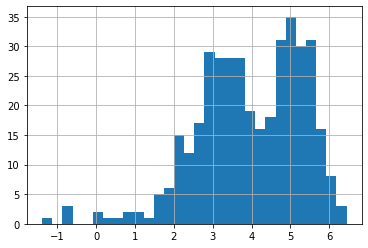

In [ ]:
np.log(df_2.SDoT_pop).hist(bins=30) # 정규성 로그변환을 통해 확보

In [ ]:
df_3 = deepcopy(df_2)
df_3.SDoT_pop = np.log(df_3.SDoT_pop) # 로그변환

## 순서형 모형 생성
- `statsmodels` 패키지의 `OrderedModel` 클래스 이용
- 프로빗 모형(프로빗(표준정규분포 누적분포함수의 역함수) 분포 가정)

In [ ]:
prob = OrderedModel(
    endog = df_3.사고내용, exog = df_3[['가해운전자 연령','day', 'hour', 'SDoT_pop',
       '학교_초', '학교_중', '학교_고', '학교_대', 'pubs', 'speedbump',
       'busstop', 'subway','따릉이_대여소수','temp','dust','humidity']],
    distr = 'probit',
    hasconst=False
)
res = prob.fit(maxiter = 100000)
res.summary()

Optimization terminated successfully.
         Current function value: 0.954358
         Iterations: 6179
         Function evaluations: 7845


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   사고내용   Log-Likelihood:                -370.29
Model:                   OrderedModel   AIC:                             778.6
Method:            Maximum Likelihood   BIC:                             853.8
Date:                Fri, 26 Aug 2022                                         
Time:                        21:21:50                                         
No. Observations:                 388                                         
Df Residuals:                     369                                         
Df Model:                          19                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
가해운전자 연령        0.0020      0.005      0.435      0.664      -0.007       0.011
day             0.0070      0.031      0.223      0.823      -0.054       0.068
hour            0.0156      0.010      1.563      0.118      -0.004       0.035
SDoT_pop       -0.0440      0.049     -0.898      0.369      -0.140       0.052
학교_초            0.0556      0.107      0.518      0.605      -0.155       0.266
학교_중            0.0154      0.140      0.110      0.913      -0.259       0.290
학교_고           -0.0025      0.015     -0.174      0.862      -0.031       0.026
학교_대            0.1177      0.419      0.281      0.779      -0.703       0.939
pubs           -0.0004      0.001     -0.301      0.764      -0.003       0.002
speedbump      -0.0008      0.002     -0.492      0.622      -0.004       0.002
busstop         0.0170      0.014      1.231      0.218      -0.010       0.044
subway         -0.0313      0.029     -1.069      0.285      -0.089       0.026
따릉이_대여소수       -0.0243      0.039     -0.630      0.529      -0.100       0.051
temp            0.0008      0.006      0.132      0.895      -0.011       0.012
dust           -0.0004      0.001     -0.312      0.755      -0.003       0.002
humidity        0.0066      0.003      2.359      0.018       0.001       0.012
부상신고사고/경상사고    -0.5000      0.412     -1.213      0.225      -1.308       0.308
경상사고/중상사고       0.5262      0.054      9.763      0.000       0.421       0.632
중상사고/사망사고       0.7622      0.150      5.070      0.000       0.468       1.057
===============================================================================
"""

In [ ]:
# 요일(월~일) 이진변수화(주말은 1, 평일은 0)
df_2.loc[df_2.day == 1,'day'] = 0
df_2.loc[df_2.day == 2,'day'] = 0
df_2.loc[df_2.day == 3,'day'] = 0
df_2.loc[df_2.day == 4,'day'] = 0
df_2.loc[df_2.day == 5,'day'] = 1
df_2.loc[df_2.day == 6,'day'] = 1

In [ ]:
# 시간대, 성별을 더미변수화
df_4 = pd.get_dummies(df_2, columns=['hour','가해운전자 성별','피해운전자 성별'])

## 최종 모델
- Ordered Probit Model
- MLE method : BFGS with Norm 1
(LASSO를 이용하여 Hessian Matrix 문제 해결)

In [ ]:
# 최종 모델
prob = OrderedModel(
    endog = df_4.사고내용, exog = df_4[['가해운전자 연령','day', 'SDoT_pop', '학교_초', '학교_중', '학교_고',
       '학교_대', 'pubs', 'speedbump', 'busstop', 'subway', 'temp',
       'humidity', 'dust', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', '가해운전자 성별_남', '피해운전자 성별_남'
       ]],
    distr = 'probit',
    hasconst=False
)
res = prob.fit(maxiter = 100000, method='bfgs', norm=1)
res.summary()

Optimization terminated successfully.
         Current function value: 0.913152
         Iterations: 140
         Function evaluations: 146
         Gradient evaluations: 146


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   사고내용   Log-Likelihood:                -354.30
Model:                   OrderedModel   AIC:                             792.6
Method:            Maximum Likelihood   BIC:                             959.0
Date:                Fri, 26 Aug 2022                                         
Time:                        21:22:29                                         
No. Observations:                 388                                         
Df Residuals:                     346                                         
Df Model:                          42                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
가해운전자 연령        0.0003      0.005      0.062      0.950      -0.009       0.010
day            -0.3568      0.142     -2.513      0.012      -0.635      -0.079
SDoT_pop       -0.0006      0.001     -1.018      0.309      -0.002       0.001
학교_초           -0.0395      0.111     -0.357      0.721      -0.257       0.178
학교_중            0.0338      0.146      0.232      0.817      -0.252       0.319
학교_고           -0.0024      0.015     -0.162      0.872      -0.032       0.027
학교_대           -0.1006      0.440     -0.229      0.819      -0.963       0.761
pubs            0.0001      0.002      0.067      0.947      -0.003       0.003
speedbump   -7.443e-05      0.002     -0.044      0.965      -0.003       0.003
busstop         0.0139      0.014      1.011      0.312      -0.013       0.041
subway         -0.0444      0.030     -1.480      0.139      -0.103       0.014
temp            0.0022      0.006      0.360      0.719      -0.010       0.014
humidity        0.0047      0.003      1.382      0.167      -0.002       0.011
dust           -0.0005      0.001     -0.355      0.722      -0.003       0.002
hour_1          0.3621      0.589      0.614      0.539      -0.793       1.517
hour_2         -0.1362      0.694     -0.196      0.844      -1.497       1.224
hour_3          0.6673      0.780      0.855      0.392      -0.862       2.196
hour_4          0.4037      0.912      0.443      0.658      -1.384       2.191
hour_5          1.2703      0.597      2.127      0.033       0.100       2.441
hour_6          0.6824      0.770      0.886      0.375      -0.827       2.191
hour_7          0.1860      0.714      0.260      0.794      -1.214       1.586
hour_8          0.2996      0.461      0.650      0.516      -0.604       1.204
hour_9          0.0954      0.464      0.206      0.837      -0.813       1.004
hour_10         0.6519      0.487      1.339      0.181      -0.302       1.606
hour_11        -0.0572      0.462     -0.124      0.901      -0.963       0.849
hour_12         0.4721      0.522      0.904      0.366      -0.552       1.496
hour_13         0.8064      0.482      1.674      0.094      -0.138       1.751
hour_14         0.4755      0.489      0.971      0.331      -0.484       1.435
hour_15         0.1564      0.460      0.340      0.734      -0.746       1.059
hour_16         0.0515      0.479      0.107      0.914      -0.888       0.991
hour_17         0.3778      0.486      0.778      0.437      -0.574       1.330
hour_18         0.3633      0.434      0.837      0.402      -0.487       1.213
hour_19         0.0651      0.454      0.143      0.886      -0.825       0.955
hour_20         0.8770      0.485      1.808      0.071      -0.074       1.828
hour_21         0.2942      0.458      0.642      0.521      -0.604       1.193
hour_22         0.5483      0.427      1.285      0.199      -0.288       1.385
hour_23         0.8074      0.457      1.7